# Event log simulator

In [2]:
import simpy
import random
import uuid
import pm4py
from pm4py.objects.log import obj as pm4py_log
import pandas as pd
import numpy as np
import scipy
import os
import sys
import pickle
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.SimCore import Resource
from src.SimCore import Scenario
from src.SimCore import Simulator
from src.SimCore import Process
from src.SimCore import AutoSimulation
import copy
import yaml
from sklearn import linear_model

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
def start_sim(seed, config_path="../Config/Sim_meta_para.yaml", model_num="",
              max_iter=100, search_time=1e5, sim_time=1e6, plot_interval=5, multi_stage=True, debug=[]):
    env = simpy.Environment()
    sim_meta1 = AutoSimulation.simulation_meta_para(env, seed, config_path)
    resource_group_list = []
    sim_max_iter = 1
    if sim_meta1.enable_resource or multi_stage:
        resource_group_list = AutoSimulation.generate_random_res_group(sim_meta1, multi_stage=multi_stage)
        sim_max_iter = max_iter
    sim_para = AutoSimulation.generate_sim_para(sim_meta1, resource_group_list)
    stages = ["_c_v_", "_c_c_",
              "_b_v_", "_b_c_",
              "_n_v_", "_n_c_"][::-1]
    #print(len(sim_para))
    stage_counter = 0
    debug.append(sim_para)
    for stage_sim_para in sim_para[::-1]:
        debug.append(stage_sim_para)
        env = simpy.Environment()
        if len(resource_group_list) > 0 and stage_counter > 1:
            resource_group = resource_group_list[2-int(stage_counter/2)]
            resource_group = AutoSimulation.update_res_pool_setting(env, resource_group)
        if stage_counter < 2:
            sim_max_iter = 1
        else:
        sim_log = pd.DataFrame()
        log_iter = []
        for i in range(sim_max_iter):
            t1 = Simulator.BPMNSimulator(seed, env, stage_sim_para, 1e10)
            if i == sim_max_iter - 1:
                env.run(until=sim_time)
                sim_log = t1.generate_log()
                break
            else:
                env.run(until=search_time)
                sim_log = t1.generate_log()
                if len(sim_log) == 0:
                    print("Sim Error Deadlock")
                    break
                lag_res_list = AutoSimulation.analyze_log_lag(sim_log, sim_meta1)
                env = simpy.Environment()
                AutoSimulation.add_res(lag_res_list, resource_group, env)
                resource_group = AutoSimulation.update_res_pool_setting(env, resource_group)
                if i % plot_interval == 0:
                    log_iter.append(sim_log)
                    print("finished iteration: ", i)
        
        
        with open("../Data/LocalTest/log_" + str(model_num) + stages[stage_counter] + "iter.pkl", "wb") as output_file:
            pickle.dump(log_iter, output_file)
        print(len(sim_log))
        sim_log.to_pickle("../Data/LocalTest/log_" + model_num + stages[stage_counter] + ".pkl")
        stage_counter = stage_counter + 1
    return 0


In [4]:
BPMNs = pd.read_pickle("../model/BPMN/sampled_BPMN_1.pickle")
BPMNs

,model,seed,cfc,num_node,cfc_norm
0,<pm4py.objects.bpmn.obj.BPMN object at 0x13910...,t-6aaa2.t-7a039.t-c85df.t-e6489.t-53dab.t-96dc...,0,10,0.000000
1,<pm4py.objects.bpmn.obj.BPMN object at 0x168b0...,t-470a1.t-7b2fe.t-981c1.t-68db6.t-2e3bc.t-95d7...,3,10,0.300000
2,<pm4py.objects.bpmn.obj.BPMN object at 0x13f1c...,t-b1ebb.t-7da96.t-b52b8.t-4743f.t-0b3d9.t-71a0...,4,10,0.400000
3,<pm4py.objects.bpmn.obj.BPMN object at 0x13f5b...,p12-4-c0ee0-ae7be.p3-5-d426c-20410.p1-1-905b3-...,7,10,0.700000
4,<pm4py.objects.bpmn.obj.BPMN object at 0x13f7f...,x1-1-db518-005d3.t-6e483.t-456b5.p1-10-1c16f-7...,8,10,0.800000
...,...,...,...,...,...
94,<pm4py.objects.bpmn.obj.BPMN object at 0x16951...,l4-39-a1bd4-29859.t-faa3c.t-1f51c.t-7d81c.t-ea...,27,30,0.900000
95,<pm4py.objects.bpmn.obj.BPMN object at 0x16954...,p26-29-6d375-b93f5.x1-24-d297e-5beec.t-6364a.x...,33,30,1.100000
96,<pm4py.objects.bpmn.obj.BPMN object at 0x16959...,x34-24-3044f-fef5c.p28-5-98dfa-f9482.x1-26-a5d...,39,30,1.300000
97,<pm4py.objects.bpmn.obj.BPMN object at 0x1695f...,p49-4-5176c-e7995.t-1354b.x21-5-a2dd9-65283.x8...,45,30,1.500000


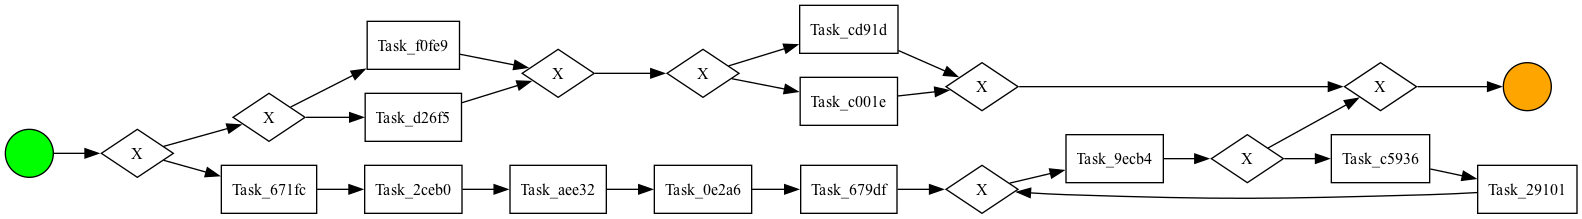

In [15]:
pm4py.view_bpmn(BPMNs[["model"]].values[11][0]) 

In [18]:
seed = BPMNs[["seed"]].values[11][0]
print(seed)

x9-6-92e55-f4ac9.t-671fc.t-2ceb0.t-aee32.t-0e2a6.t-679df.l1-2-ac6fb-26ffb.t-9ecb4.t-c5936.t-29101.x1-1-14b44-97e64.t-d26f5.t-f0fe9.x1-1-44cd7-8d2ab.t-c001e.t-cd91d


In [38]:
env = simpy.Environment()
sim_meta1 = AutoSimulation.simulation_meta_para(env, seed, "../config/Sim_meta_para.yaml")
resource_group_list = []
sim_max_iter = 1
resource_group_list = AutoSimulation.generate_random_res_group(sim_meta1, multi_stage=False)
sim_para = AutoSimulation.generate_sim_para(sim_meta1, resource_group_list)
sim_log = pd.DataFrame()
stage_sim_para = sim_para[0]
t1 = Simulator.BPMNSimulator(seed, env, stage_sim_para, 1e10)
env.run(until=1e5)
sim_log = t1.generate_log()

In [39]:
sim_log

,CaseID,Activity,Type,RegistrationTime,StartTime,EndTime,TaskDuration,TimeLapse,ExecutionLapse,GateAttr,Resource,WaitTime
0,f4e6dc836cb24524bc175aef6dd568f7,d26f5,Task,2022-01-01 02:16:00,2022-01-01 09:00:00,2022-01-01 10:36:00,96,500,96,0.388817,"[[540, worker_0.0, 0]]",0
1,f4e6dc836cb24524bc175aef6dd568f7,cd91d,Task,2022-01-01 10:36:00,2022-01-01 10:41:00,2022-01-01 12:01:00,80,85,80,0.625532,"[[641, worker_1.1, 5]]",5
2,e0e2492663914a3c9143c609bceca8a7,d26f5,Task,2022-01-01 03:24:00,2022-01-01 10:36:00,2022-01-01 12:23:00,107,539,107,0.316169,"[[636, worker_0.0, 96]]",96
3,e0e2492663914a3c9143c609bceca8a7,c001e,Task,2022-01-01 12:23:00,2022-01-01 12:23:00,2022-01-01 15:13:00,170,170,170,0.354717,"[[743, worker_2.0, 0]]",0
4,758ac869ef8c498b915d79f26d6bf6d9,d26f5,Task,2022-01-01 05:40:00,2022-01-01 12:23:00,2022-01-01 14:12:00,109,512,109,0.478534,"[[743, worker_0.0, 203]]",203
...,...,...,...,...,...,...,...,...,...,...,...,...
1653,22579833143d4727ab0d815c0ad2c813,2ceb0,Task,2022-01-30 12:41:00,2022-01-30 13:25:00,2022-01-30 13:45:00,20,64,20,0.025878,"[[42565, worker_1.1, 44]]",44
1654,22579833143d4727ab0d815c0ad2c813,aee32,Task,2022-01-30 13:45:00,2022-03-07 15:31:00,2022-03-08 10:04:00,153,53059,1113,0.025878,"[[94531, worker_3.0, 51946], [95580, worker_3....",51946
1655,22579833143d4727ab0d815c0ad2c813,0e2a6,Task,2022-03-08 10:04:00,2022-03-08 11:31:00,2022-03-08 12:50:00,79,166,79,0.025878,"[[95731, worker_3.0, 87]]",87
1656,22579833143d4727ab0d815c0ad2c813,679df,Task,2022-03-08 12:50:00,2022-03-08 14:06:00,2022-03-08 15:11:00,65,141,65,0.025878,"[[95886, worker_2.0, 76]]",76


In [34]:
sim_para[0].task_para[0].resource

In [ ]:
if sim_meta1.enable_resource or multi_stage:
        
        sim_max_iter = max_iter
    sim_para = AutoSimulation.generate_sim_para(sim_meta1, resource_group_list)
    stages = ["_c_v_", "_c_c_",
              "_b_v_", "_b_c_",
              "_n_v_", "_n_c_"][::-1]
    #print(len(sim_para))
    stage_counter = 0
    debug.append(sim_para)
    for stage_sim_para in sim_para[::-1]:
        debug.append(stage_sim_para)
        env = simpy.Environment()
        if len(resource_group_list) > 0 and stage_counter > 1:
            resource_group = resource_group_list[2-int(stage_counter/2)]
            resource_group = AutoSimulation.update_res_pool_setting(env, resource_group)
        if stage_counter < 2:
            sim_max_iter = 1
        else:
        sim_log = pd.DataFrame()
        log_iter = []
        for i in range(sim_max_iter):
            t1 = Simulator.BPMNSimulator(seed, env, stage_sim_para, 1e10)
            if i == sim_max_iter - 1:
                env.run(until=sim_time)
                sim_log = t1.generate_log()
                break
            else:
                env.run(until=search_time)
                sim_log = t1.generate_log()
                if len(sim_log) == 0:
                    print("Sim Error Deadlock")
                    break
                lag_res_list = AutoSimulation.analyze_log_lag(sim_log, sim_meta1)
                env = simpy.Environment()
                AutoSimulation.add_res(lag_res_list, resource_group, env)
                resource_group = AutoSimulation.update_res_pool_setting(env, resource_group)
                if i % plot_interval == 0:
                    log_iter.append(sim_log)
                    print("finished iteration: ", i)